# ARIMA MODEL

### SETUP

In [1]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [18, 10]

### DATA PREPROCESSING

In [3]:
# Load data
xau = pd.read_csv(r"C:\Users\GRACE ESTRADA\OneDrive\Desktop\XAUUSD.csv", parse_dates = ['Date'])

In [4]:
# Set index to date
xau = xau.sort_values('Date', ascending = True)
xau = xau.set_index('Date')

In [5]:
# Replace 0 values with 0.00001 to avoid issues during transformation
xau[xau < 0] = 0.00001

In [6]:
# Ensure that the frequency is set to business days
xau = xau.asfreq('B')

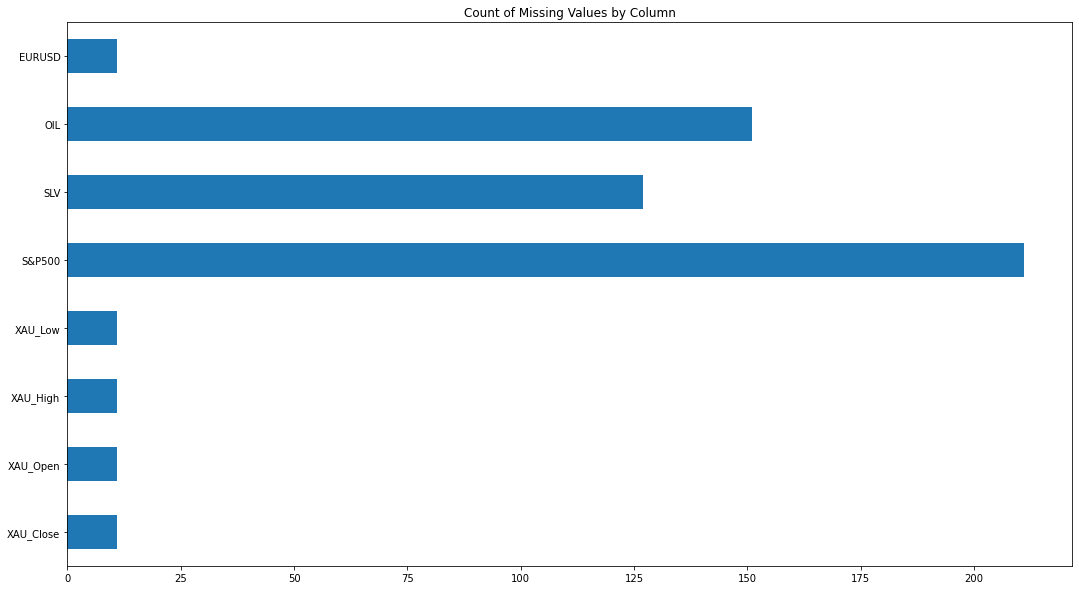

In [7]:
# Plot missing values
xau.isna().sum().plot(kind = 'barh')

plt.title('Count of Missing Values by Column')
plt.show()

In [8]:
# Fill in missing values with forward fill
xau = xau[1:].ffill()

# Ensure that there are no more missing values
assert xau.isna().sum().sum() == 0

### STATISTICAL TESTS

PRIOR TRANSFORMATION

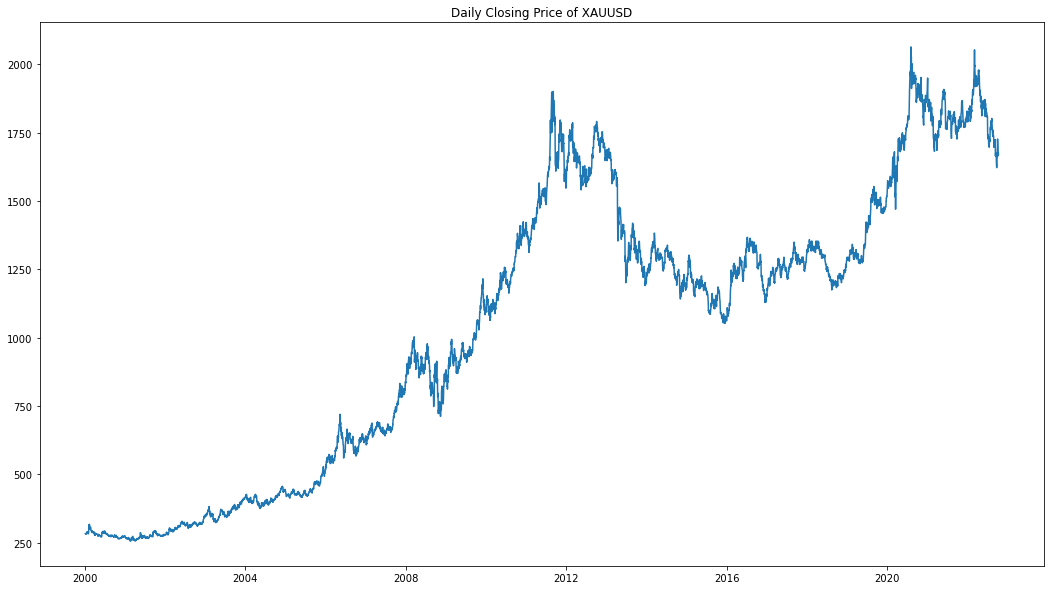

In [9]:
# Plot of XAU Closing Price

plt.plot(xau['XAU_Close'])
plt.title('Daily Closing Price of XAUUSD')
plt.show()

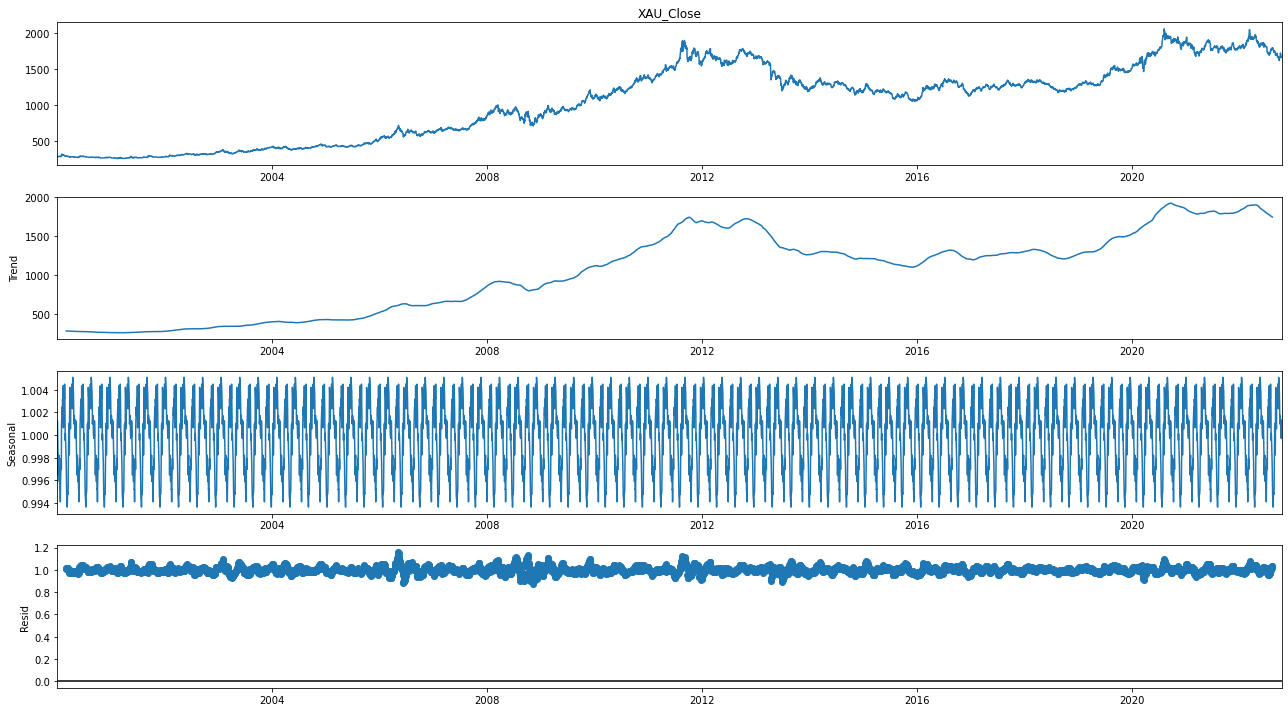

In [10]:
# Decompose
seasonal_decompose(xau['XAU_Close'], model='multiplicable', period=90).plot()
plt.show()


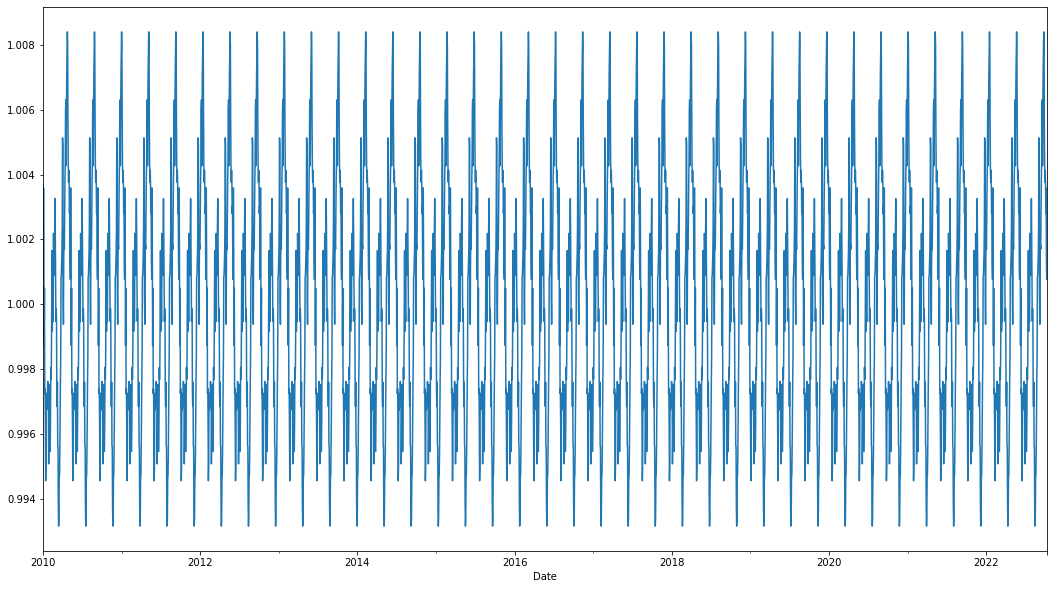

In [11]:
seasonal_decompose(xau['XAU_Close']['2010':], model='multiplicable', period=90).seasonal.plot()
plt.show()

### MODEL TUNING  [ALL VARIABLES]

#### MODEL BUILDING

In [12]:
# Define Endog Variables

endog = xau['XAU_Close']
endog_train = xau['XAU_Close']['2000-01-01':'2021-12-31']
endog_test = xau[['XAU_Close']]['2022-01-01':]

### OPTIMIZE

In [13]:
def optimize_ETS(endog, param_list):
    """
        Return dataframe with parameters and corresponding MSE and AIC
        
        order_list - list with error, trend, and seasonality parameters
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(param_list):
        model = ETSModel(endog,
                         error = order[0],
                         trend = order[1],
                         seasonal = order[2],
                         damped_trend = True,
                         seasonal_periods = order[3]).fit()
          
        aic = model.aic
        mse = model.mse
        results.append([order, aic, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(e, t, s)", "AIC", "MSE"]
    #Sort in ascending order, lower MSE is better
    result_df = result_df.sort_values(by='MSE', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
e = ['add', 'mul']
t = ['add', 'mul']
s = ['add', 'mul']
p = [5, 12, 20, 30, 90]

param_list = list(product(e,t,s,p))

In [15]:
result_df = optimize_ETS(endog_train, param_list)
result_df

  0%|          | 0/40 [00:00<?, ?it/s]

,"(e, t, s)",AIC,MSE
0,"(mul, mul, mul, 90)",41736.552753,0.000112
1,"(mul, add, mul, 90)",41737.183074,0.000112
2,"(mul, add, add, 90)",41743.642183,0.000112
3,"(mul, mul, add, 90)",41752.463402,0.000112
4,"(mul, mul, mul, 20)",41645.463423,0.000113
5,"(mul, add, mul, 20)",41646.109726,0.000113
6,"(mul, mul, add, 20)",41647.604017,0.000113
7,"(mul, add, add, 20)",41648.062295,0.000113
8,"(mul, add, add, 30)",41676.007259,0.000113
9,"(mul, mul, add, 30)",41676.015447,0.000113


In [16]:
# Fit the model using the best parameters
model = ETSModel(
    endog_train,
    error="mul",
    trend="mul",
    seasonal="mul",
    damped_trend=True,
    seasonal_periods=90)

res = model.fit()
print(res.summary())

                                 ETS Results                                  
Dep. Variable:              XAU_Close   No. Observations:                 5739
Model:                      ETS(MMdM)   Log Likelihood              -20771.276
Date:                Thu, 20 Oct 2022   AIC                          41736.553
Time:                        15:59:19   BIC                          42382.092
Sample:                    01-04-2000   HQIC                         41961.232
                         - 12-31-2021   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.014     70.520      0.000       0.972       1.028
smoothing_trend      9.999e-05      0.007      0.014      0.988      -0.013       0.014
smoothing_season

#### MODEL EVALUATION

#### FORECASTING

In [17]:
predict = res.get_prediction(start = '2000-01-4', end = '2022-10-12')
predictions = predict.predicted_mean

xau['Predicted'] = predictions
forecast = xau[xau[['Predicted']].index.isin(endog_test.index)]

xau.head()

,XAU_Close,XAU_Open,XAU_High,XAU_Low,S&P500,SLV,OIL,EURUSD,Predicted
Date,,,,,,,,,
2000-01-04,282.45,288.75,282.45,282.45,1399.4,5.375,25.55,1.0312,285.882504
2000-01-05,281.00,281.50,281.00,281.00,1402.1,5.210,24.91,1.0316,281.284120
2000-01-06,281.23,280.12,281.23,281.23,1403.5,5.167,24.78,1.0324,279.694181
2000-01-07,281.75,281.15,281.75,281.75,1441.5,5.195,24.22,1.0292,280.855550
2000-01-10,281.48,281.88,281.48,281.48,1457.6,5.190,24.67,1.0257,280.683110


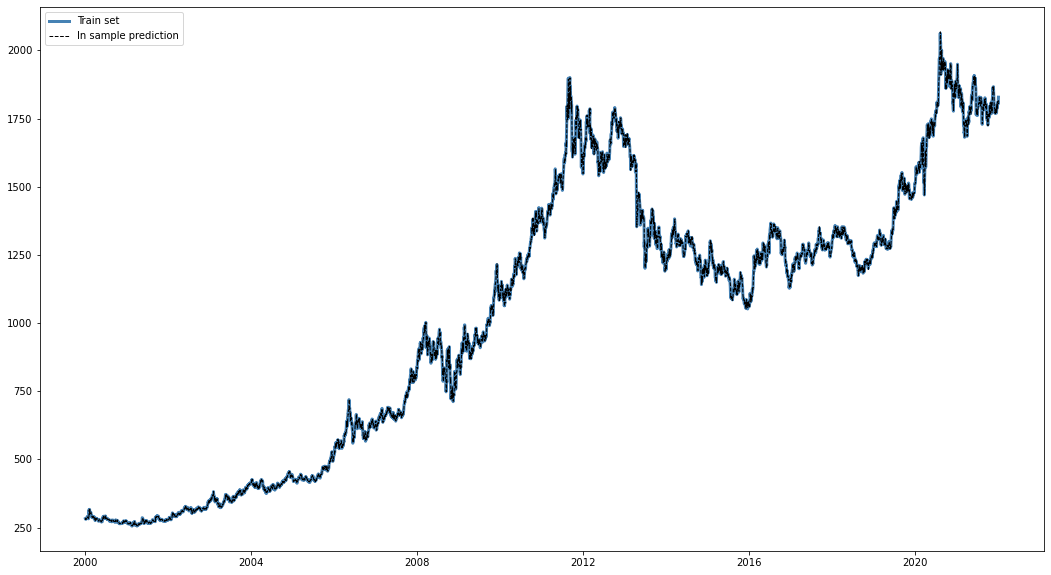

In [18]:
#In-sample ETS forecast

fig, ax = plt.subplots()

ax.plot(xau['XAU_Close'][:'2021'], 'steelblue', label = 'Train set', linewidth = 3)
ax.plot(xau['Predicted'][:'2021'], 'black', linestyle = 'dashed', label = 'In sample prediction', linewidth = 1)

ax.legend(loc = 'upper left')

plt.show()


In [19]:
# In-sample ETS evaluation

r2 = r2(xau['XAU_Close'][:'2021'], xau['Predicted'][:'2021'])
mse = mse(xau['XAU_Close'][:'2021'], xau['Predicted'][:'2021'])
rmse = np.sqrt(mse)

print(f"R2:{r2}\nMSE: {mse}\nRMSE: {rmse}")

R2:0.9994623393436289
MSE: 138.05720427928765
RMSE: 11.749774648021452


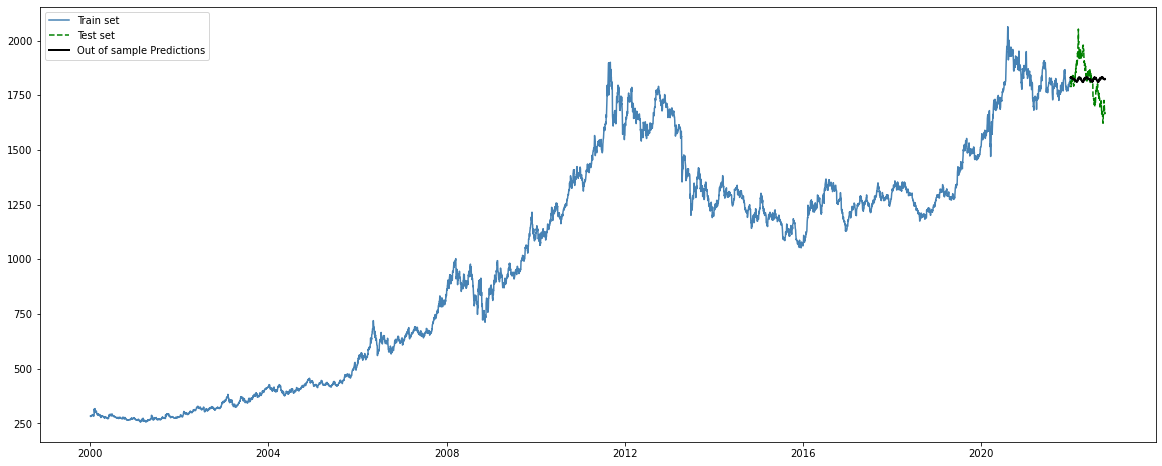

In [20]:
# Out-of-sample ETS forecast (zoomed-out)
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots()


ax.plot(endog_train, 'steelblue', label = 'Train set')
ax.plot(endog_test, 'green', linestyle = 'dashed', label = 'Test set')
ax.plot(forecast['Predicted'], 'black', linewidth = 2,label = 'Out of sample Predictions')

ax.legend(loc = 'upper left')

plt.show()


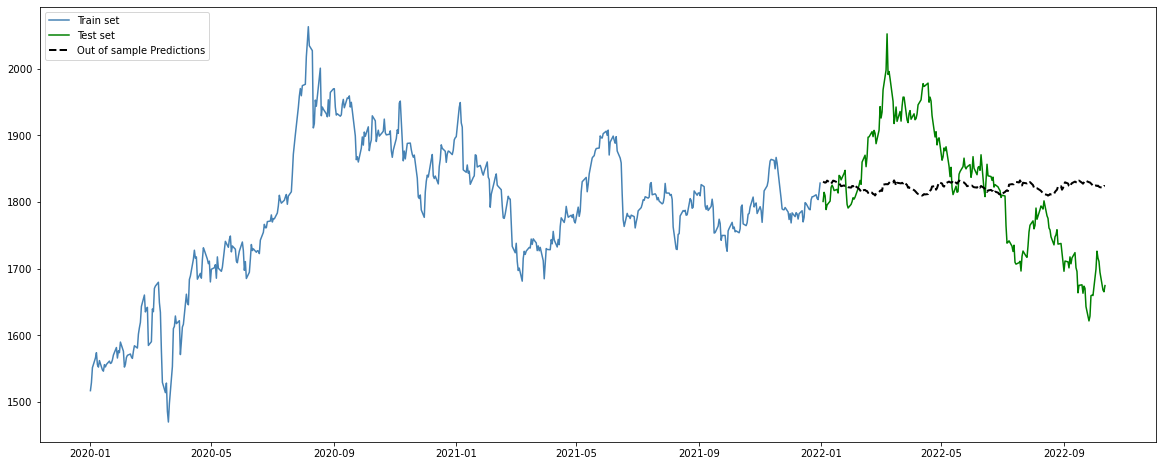

In [21]:
# Out-of-sample forecast (zoomed-in)
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots()


ax.plot(endog_train['2020':], 'steelblue', label = 'Train set')
ax.plot(endog_test, 'green', label = 'Test set')
ax.plot(forecast['Predicted'], 'black', linestyle = 'dashed', linewidth = 2,label = 'Out of sample Predictions')

ax.legend(loc = 'upper left')

plt.show()

In [22]:
# Out-of-sample evaluation
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

endog_test['Predicted'] = predict.predicted_mean

r2 = r2(endog_test['XAU_Close'], endog_test['Predicted'])
mse = mse(endog_test['XAU_Close'], endog_test['Predicted'])
rmse = np.sqrt(mse)

print(f"R2:{r2}\nMSE: {mse}\nRMSE: {rmse}")

R2:-0.043231195133251576
MSE: 8541.716938941008
RMSE: 92.42140952691106


In [24]:
# Export out-of-sample predictions to CSV

xau.to_csv('ETS_forecast.csv')